In [4]:
# diff_my_minus_wgm.py
from __future__ import annotations

import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import pygmt


# =============================
# 0) 区域与模板（南海）
# =============================
REGION = [111.0, 117.0, 14.5, 18.5]  # [W, E, S, N]  <-- 修正为南海
DLON = 1 / 60.0  # 1 arc-min in degree

LON_T = np.round(np.arange(REGION[0], REGION[1] + DLON, DLON), 10)
LAT_T = np.round(np.arange(REGION[2], REGION[3] + DLON, DLON), 10)

# =============================
# 1) 输入输出路径
# =============================
MY_GRID = Path(r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\CBA_expand_crop\CBA_raw_expand5.0deg_5.0deg.nc")
MY_FIELD = "CBA_raw"   # 你要对比的变量：如果要 FAA，就改成 "FAA"

WGM_GRID = Path(r"E:\wjy\Gravity\SCS_Gravity\data\WGM2012\grid_bouguer_111_117_14.5_18.5.txt")  # WGM2012 Bouguer txt

OUTDIR = Path(r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\Compare_WGM2012")
OUTDIR.mkdir(parents=True, exist_ok=True)


# =============================
# 2) 读数据：nc/grd/txt 都支持
# =============================
def open_any_grid(p: Path, varname: str = "z", prefer_var: str | None = None) -> xr.DataArray:
    """
    - nc/grd: 读取指定变量 prefer_var（强烈建议显式给）
    - txt: 读取 lon lat val 三列
    """
    p = Path(p)
    suf = p.suffix.lower()

    if suf in [".nc", ".grd", ".nc4"]:
        ds = xr.open_dataset(p)

        if prefer_var is not None:
            if prefer_var not in ds.data_vars:
                raise ValueError(
                    f"Variable '{prefer_var}' not found in {p}. Available: {list(ds.data_vars)}"
                )
            da = ds[prefer_var]
        else:
            # fallback: choose first 2D var
            cand = None
            for k, v in ds.data_vars.items():
                if v.ndim == 2:
                    cand = k
                    break
            if cand is None:
                raise ValueError(f"No 2D variable found in {p}. data_vars={list(ds.data_vars)}")
            da = ds[cand]

        ds.close()

        # normalize coord names
        if "x" in da.dims:
            da = da.rename({"x": "lon"})
        if "y" in da.dims:
            da = da.rename({"y": "lat"})
        if "longitude" in da.coords:
            da = da.rename({"longitude": "lon"})
        if "latitude" in da.coords:
            da = da.rename({"latitude": "lat"})

        da = da.rename(varname)

        # ensure ascending
        if np.any(np.diff(da["lon"].values) < 0):
            da = da.sortby("lon")
        if np.any(np.diff(da["lat"].values) < 0):
            da = da.sortby("lat")

        return da

    # txt: lon lat val
    df = pd.read_csv(p, delim_whitespace=True, header=None, names=["lon", "lat", "val"], comment="#")
    lons = np.sort(df["lon"].unique())
    lats = np.sort(df["lat"].unique())
    Z = (
        df.pivot(index="lat", columns="lon", values="val")
        .reindex(index=lats, columns=lons)
        .values
    )
    da = xr.DataArray(Z, coords={"lat": lats, "lon": lons}, dims=("lat", "lon"), name=varname)

    # ensure ascending
    da = da.sortby(["lat", "lon"])
    return da


# =============================
# 3) 关键修复：不依赖 rioxarray 的 grdsample
# =============================
def _da_to_gmt_nc3(da: xr.DataArray, out_nc: Path) -> None:
    """
    写出 GMT 兼容网格：
    - NetCDF3（scipy engine）
    - 坐标名 x/y，变量名 z
    """
    da = da.astype(np.float32)

    # normalize coords
    if "lon" not in da.coords and "x" in da.coords:
        da = da.rename({"x": "lon"})
    if "lat" not in da.coords and "y" in da.coords:
        da = da.rename({"y": "lat"})
    if "lon" not in da.coords or "lat" not in da.coords:
        raise ValueError(f"Grid missing lon/lat coords, coords={list(da.coords)}")

    if np.any(np.diff(da["lon"].values) < 0):
        da = da.sortby("lon")
    if np.any(np.diff(da["lat"].values) < 0):
        da = da.sortby("lat")

    ds = da.rename("z").to_dataset().rename({"lon": "x", "lat": "y"})
    out_nc.parent.mkdir(parents=True, exist_ok=True)
    ds.to_netcdf(out_nc, engine="scipy")  # NetCDF3


def _read_gmt_grid(out_nc: Path) -> xr.DataArray:
    ds = xr.open_dataset(out_nc)
    # usually var is 'z'
    vname = "z" if "z" in ds.data_vars else list(ds.data_vars)[0]
    da = ds[vname]
    ds.close()

    # back to lon/lat
    if "x" in da.dims:
        da = da.rename({"x": "lon"})
    if "y" in da.dims:
        da = da.rename({"y": "lat"})
    return da.sortby(["lat", "lon"])


def align_to_template(da: xr.DataArray) -> xr.DataArray:
    """
    目标：
    1) 先用 GMT grdsample 统一到 REGION + 1' gridline
    2) 再用 xarray interp 到 LON_T/LAT_T 并用 nearest snap 保证坐标逐元素一致
    """
    td = Path(tempfile.mkdtemp(prefix="wgm_align_"))
    in_nc = td / "in.nc"
    out_nc = td / "out.nc"

    _da_to_gmt_nc3(da, in_nc)

    pygmt.grdsample(
        grid=str(in_nc),
        outgrid=str(out_nc),
        region=REGION,
        spacing="1m",
        registration="gridline",
        interpolation="b",  # bicubic-like
        verbose="q",
    )

    da2 = _read_gmt_grid(out_nc).rename("z")

    # 强制对齐到模板轴（避免 240x360 vs 241x361 之类的 exact align 问题）
    da2 = da2.interp(lon=LON_T, lat=LAT_T, method="linear")
    da2 = da2.interp(lon=LON_T, lat=LAT_T, method="nearest")
    return da2.rename("z").sortby(["lat", "lon"])


def save_txt(da: xr.DataArray, path: Path) -> None:
    df = pygmt.grd2xyz(da, output_type="pandas")
    df.to_csv(path, sep=" ", header=False, index=False, float_format="%.6f")


# =============================
# 4) 主流程：读取 → 对齐 → 差值 → 出图
# =============================
def main():
    mine0 = open_any_grid(MY_GRID, varname="z", prefer_var=MY_FIELD)
    wgm0 = open_any_grid(WGM_GRID, varname="z", prefer_var=None)

    mine = align_to_template(mine0)
    wgm = align_to_template(wgm0)

    # common mask
    mask = np.isfinite(mine.values) & np.isfinite(wgm.values)
    A = xr.where(mask, mine, np.nan)
    B = xr.where(mask, wgm, np.nan)

    diff = (A - B).rename("z")  # mine - WGM
    bias = float(np.nanmedian(diff.values))
    diff = diff - bias  # 去掉整体偏置（只比较形态/相对差异）

    out_nc = OUTDIR / f"diff_{MY_FIELD}_minus_WGM2012_01m.nc"
    out_txt = OUTDIR / f"diff_{MY_FIELD}_minus_WGM2012_01m.txt"
    out_png = OUTDIR / f"map_diff_{MY_FIELD}_minus_WGM2012.png"

    diff.to_netcdf(out_nc)
    save_txt(diff, out_txt)

    # plot
    fig = pygmt.Figure()
    V = float(np.nanpercentile(np.abs(diff.values), 98))
    V = np.ceil((0 if not np.isfinite(V) else V) / 10) * 10

    pygmt.makecpt(cmap="vik", series=[-V, V, max(V / 20, 1e-6)], continuous=True)
    fig.grdimage(diff, region=REGION, projection="M16c", cmap=True, nan_transparent=True)
    fig.coast(shorelines="0.5p,black", frame=["WSen", "xaf", "yaf"])
    if V > 0:
        fig.grdcontour(diff, interval=max(V / 20, 1e-3), limit=[0, 0], pen="1p,black")
    fig.colorbar(frame=[f"xafg{max(V/10, 1e-6)}", f'y+l"Δ ({MY_FIELD}) (mGal), mine − WGM2012 (bias-removed)"'])
    fig.savefig(out_png, dpi=500)

    arr = diff.values
    print(
        f"Δ(mine−WGM) after median-bias removal: "
        f"mean={np.nanmean(arr):.2f}  std={np.nanstd(arr):.2f}  "
        f"min={np.nanmin(arr):.2f}  max={np.nanmax(arr):.2f}  (mGal)"
    )
    print("Saved:", out_nc)
    print("Saved:", out_txt)
    print("Saved:", out_png)
    print("Done:", OUTDIR)


if __name__ == "__main__":
    main()


C:\Users\user\AppData\Local\Temp\ipykernel_27584\1507486692.py:88: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(p, delim_whitespace=True, header=None, names=["lon", "lat", "val"], comment="#")
C:\Users\user\AppData\Local\Temp\ipykernel_27584\1507486692.py:217: FutureWarning: The 'interval' parameter has been deprecated since v0.12.0 and will be removed in v0.16.0. Please use 'levels' instead.
  fig.grdcontour(diff, interval=max(V / 20, 1e-3), limit=[0, 0], pen="1p,black")


Δ(mine−WGM) after median-bias removal: mean=-1.43  std=11.02  min=-75.07  max=50.45  (mGal)
Saved: E:\wjy\Gravity\SCS_Gravity\out\Outdata\Compare_WGM2012\diff_CBA_raw_minus_WGM2012_01m.nc
Saved: E:\wjy\Gravity\SCS_Gravity\out\Outdata\Compare_WGM2012\diff_CBA_raw_minus_WGM2012_01m.txt
Saved: E:\wjy\Gravity\SCS_Gravity\out\Outdata\Compare_WGM2012\map_diff_CBA_raw_minus_WGM2012.png
Done: E:\wjy\Gravity\SCS_Gravity\out\Outdata\Compare_WGM2012


In [3]:
#OJP区域底图
# ojp_fig1_style_final.py
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import pygmt

# ===============【需要时在这里改 · 全局参数】===============
# 研究区与投影
REGION = [111,117,14.5,18.5]
PROJ   = "M16c"

# 站位 CSV（IODP³ 上级页下载的 Drilled_Holes.csv）
SITES_CSV = r"E:\wjy\Gravity\OJP_Gravity\data\OJP_sites_filtered.csv"   # ← 改成你本地的路径

# 底图数据：优先用 GEBCO（与姜文Fig.1一致），没有就用 GMT 远程 1′ 地形
USE_GEBCO   = False                   # True：用本地 GEBCO；False：用 earth_relief_01m
GEBCO_PATH  = r"E:\wjy\Gravity\data\GEBCO_2021.nc"  # 仅当 USE_GEBCO=True 时会用到


# 只画海盆：True=陆地用灰色面、不参与明暗；False=海陆同一色带
SEA_ONLY    = True

# --- 颜色带设置（SCM: vik）---
CPT_NAME    = "vik"                   # 就用 vik
CPT_MODE    = "half_neg"              # 选 "half_neg"（只海盆）或 "symmetric"（海陆同画）
CPT_STEP    = 100                     # 色带步长（m）；数值越小层次越细
# （可选）手动指定范围，比如 [-8000, 0]；不指定则自动根据网格/模式计算
CPT_SERIES_MANUAL = None              # 例如 [-8000, 0, 50] 或 [-8000, 8000, 100]

# 站号标签整体上提的距离（越大越靠上）
LABEL_OFFSET = "0c/0.20c"             # 可调到 0.18c~0.25c
LABEL_FONT   = "9p,black,Helvetica-Bold"
LABEL_FILL   = "white@60"             # 半透明白底（white@透明度）
LABEL_BOX    = "2p/2p"                # 留白
LABEL_PEN    = "0.2p,black"

# 高亮站位（只给这些站号加标签；其余只画点不标号）
HIGHLIGHT_DSDP = {288, 289, 586}
HIGHLIGHT_ODP  = {803, 804, 805, 806, 807, 1183, 1184, 1185, 1186, 1187}

# 可选：你的测线（两种输入二选一，不填则跳过）
LINES_CSV   = ""                      # CSV 列：line_id,lon,lat
LINES_SHP   = ""                      # Shapefile/GeoJSON 路径

# 输出图名
OUTPNG = r"E:\wjy\Gravity\out\pic\OJP_Fig1a_style.png"
# =========================================================


# 读取站位 CSV（IODP³ Drilled_Holes.csv）
sites = pd.read_csv(SITES_CSV)
# 规范字段名（不同版本大小写不一）
colmap = {c.lower(): c for c in sites.columns}
for need in ["leg", "site", "latitude", "longitude"]:
    assert need in colmap, f"CSV 缺少字段: {need}"
sites = sites.rename(columns={
    colmap["leg"]: "leg", colmap["site"]: "site",
    colmap["latitude"]: "lat", colmap["longitude"]: "lon"
})
sites = sites.dropna(subset=["lat", "lon"])
# 裁剪到研究区
sites = sites[(sites["lon"] >= REGION[0]) & (sites["lon"] <= REGION[1]) &
              (sites["lat"] >= REGION[2]) & (sites["lat"] <= REGION[3])]

# 给每条记录标注属于 DSDP / ODP / 其他（便于分层作图）
def _program_from_leg(x):
    try:
        v = float(x)
    except Exception:
        return "Other"
    if 1 <= v <= 96:
        return "DSDP"
    if 100 <= v <= 210:
        return "ODP"
    return "Other"

sites["program"] = sites["leg"].apply(_program_from_leg)

# 方便筛选：站号转数值
def _site_num(s):
    try:
        return int(float(str(s).split()[0]))
    except Exception:
        return np.nan
sites["site_num"] = sites["site"].apply(_site_num)

# 读取底图格网
if USE_GEBCO and os.path.exists(GEBCO_PATH):
    grid = pygmt.grdcut(grid=GEBCO_PATH, region=REGION)
else:
    grid = pygmt.datasets.load_earth_relief(resolution="01m", region=REGION)

# 计算明暗（hillshade）
shade = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# 如果只画海盆：把 >0 的高程裁成 NaN，再用 coast 轻涂陆地
grid_to_plot = grid
if SEA_ONLY:
    grid_to_plot = pygmt.grdclip(grid=grid, above=[0, np.nan])  # 陆地置 NaN

# --------- 这里是“vik 色带”的关键改动（相当于你原来的 makecpt 那一行）---------
# 1) 若手动指定了范围，直接用
if CPT_SERIES_MANUAL is not None:
    pygmt.makecpt(cmap=CPT_NAME, series=CPT_SERIES_MANUAL, continuous=True)
else:
    # 2) 动态计算范围
    gmin = float(grid.min().values)   # 用原始 grid 统计（不受 SEA_ONLY 影响）
    gmax = float(grid.max().values)
    if CPT_MODE == "symmetric":
        # 海陆同画：围绕 0 对称，0 为白色枢轴
        M = max(abs(gmin), abs(gmax), 2000)      # 给个最小对称幅度
        pygmt.makecpt(cmap=CPT_NAME, series=[-M, M, CPT_STEP], continuous=True)
    else:
        # 只海盆：只用负半边到 0（让 0 处近白）
        lo = min(-8000, gmin)                    # 下界给个保守值
        pygmt.makecpt(cmap=CPT_NAME, series=[lo, 0, CPT_STEP], continuous=True)
# ---------------------------------------------------------------------------

# 开始画图
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain", FORMAT_GEO_MAP="dddF", MAP_TICK_LENGTH_PRIMARY="0.15c")

# 底图 + 明暗（使用刚创建的 CPT）
fig.grdimage(grid=grid_to_plot, cmap=True, projection=PROJ, region=REGION, shading=shade)

# 海岸线/边界/网格
if SEA_ONLY:
    fig.coast(land="gray90", shorelines="0.25p,black", borders="1/0.15p,gray40",
              frame=["WSen", "xafg", "yafg"])
else:
    fig.coast(shorelines="0.25p,black", borders="1/0.15p,gray40",
              frame=["WSen", "xafg", "yafg"])

# 画测线（CSV：按 line_id 分组连线；或直接画 Shapefile）
if LINES_CSV and os.path.exists(LINES_CSV):
    dfL = pd.read_csv(LINES_CSV)
    if {"line_id", "lon", "lat"}.issubset(dfL.columns):
        for lid, g in dfL.groupby("line_id"):
            fig.plot(x=g["lon"], y=g["lat"], pen="1.0p,0/0/0,.-")
if LINES_SHP and os.path.exists(LINES_SHP):
    fig.plot(data=LINES_SHP, pen="1.0p,0/0/0,.-")

# 分层画站位：DSDP（白）与 ODP（金）
dsdp = sites[sites["program"] == "DSDP"]
odp  = sites[sites["program"] == "ODP"]
if not dsdp.empty:
    fig.plot(x=dsdp["lon"], y=dsdp["lat"], style="s0.25c", fill="white", pen="0.6p,black")
if not odp.empty:
    fig.plot(x=odp["lon"],  y=odp["lat"],  style="s0.28c", fill="gold",  pen="0.6p,black")

# 只给“高亮站位”加标签（统一向上偏移，半透明白底）
def put_label(x, y, text):
    fig.text(
        x=float(x), y=float(y), text=str(text),
        justify="BC", offset=LABEL_OFFSET,
        font=LABEL_FONT, fill=LABEL_FILL, clearance=LABEL_BOX, pen=LABEL_PEN
    )

lab = sites[sites["site_num"].isin(HIGHLIGHT_DSDP.union(HIGHLIGHT_ODP))].copy()
for _, r in lab.iterrows():
    put_label(r["lon"], r["lat"], int(r["site_num"]))

# colorbar：底部居中、稍抬高、去引号
fig.colorbar(
    position="JBC+w14c/0.45c+o0c/0.8c+h",   # 底部居中，向上偏 0.8 cm
    frame="a1000f500+lBathymetry/topography (m)"
)

fig.savefig(OUTPNG, dpi=300)
print(f"Saved: {OUTPNG}")

# 顺带导出筛选后的站位，便于入库
sites.sort_values(["program", "site_num"]).to_csv(r"E:\wjy\Gravity\out\pic\OJP_sites_filtered.csv", index=False)
print("Saved: OJP_sites_filtered.csv")


AssertionError: CSV 缺少字段: latitude

Done.
Outputs: E:\wjy\Gravity\SCS_Gravity\out\Outdata\filter\compare_qc
Recommended LP width (km): 300
Metrics table: E:\wjy\Gravity\SCS_Gravity\out\Outdata\filter\compare_qc\filter_metrics_lp.csv


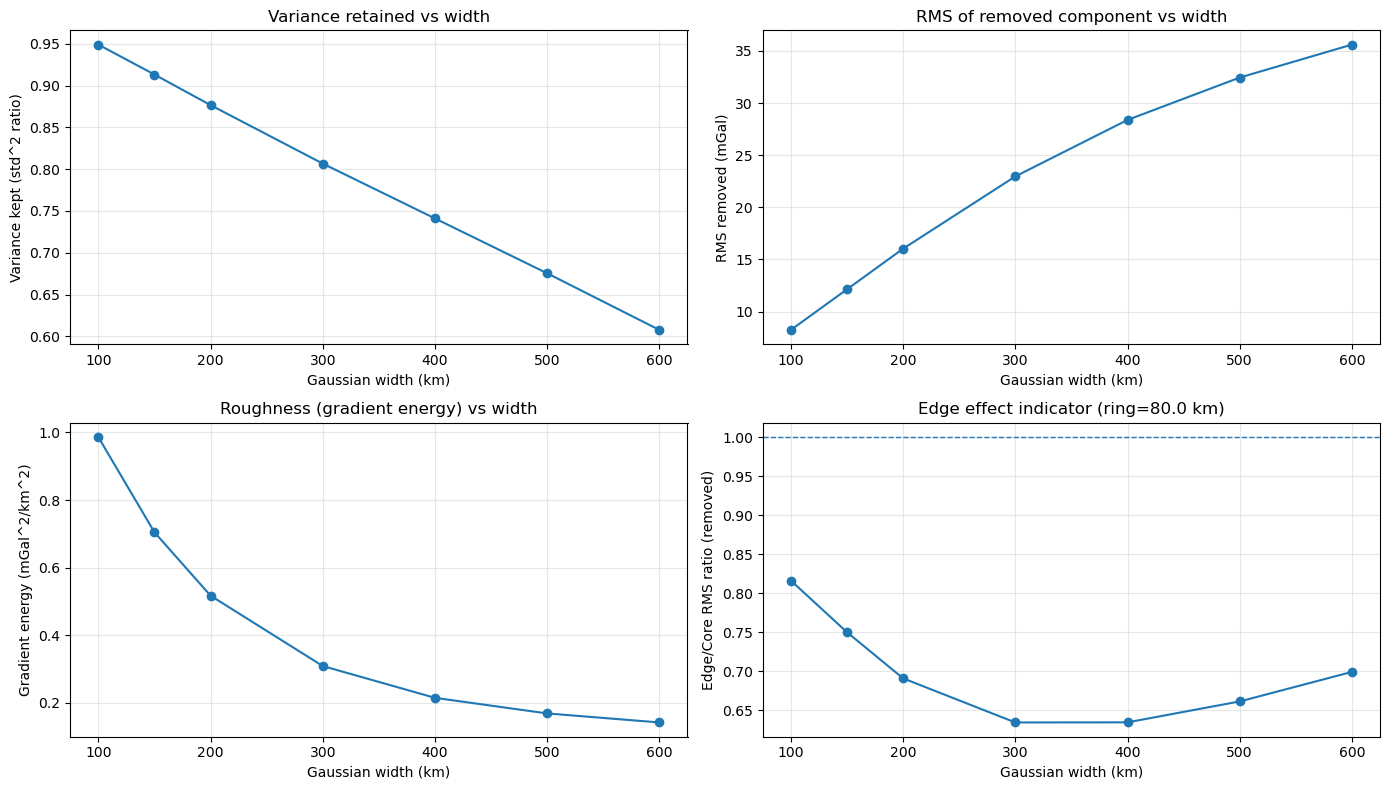

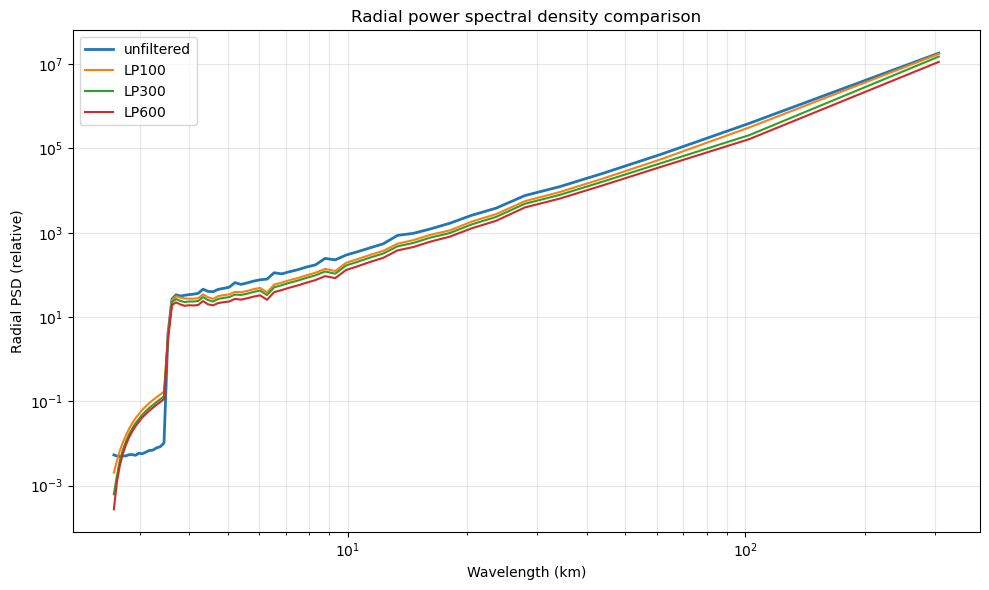

In [4]:
# compare_filters_sc_v2.py
# -*- coding: utf-8 -*-
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


# ================== 用户需要改的配置 ==================
IN_PATH = r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\Sediment_Correction_expand_crop\CBA_sed_expand5.0deg_5.0deg_rho2300.nc"
FILTER_DIR = Path(r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\filter")
REGION_TARGET = [111, 117, 14.5, 18.5]  # lonmin lonmax latmin latmax

# 可选：指定剖面（lon,lat）起点终点；不想画剖面就留空 []
PROFILES = [
    # ((111.2, 18.2), (116.8, 14.8)),
]

EDGE_RING_KM = 80.0

# 是否计算功率谱（如果你只想先跑指标，可设 False）
PSD_ENABLE = True
PSD_NBINS = 60

OUT_DIR = FILTER_DIR / "compare_qc"
OUT_DIR.mkdir(parents=True, exist_ok=True)
# =====================================================


# ------------------ 读网格 ------------------
def _pick_data_var(ds: xr.Dataset) -> xr.DataArray:
    for v in ds.data_vars:
        da = ds[v]
        if da.ndim == 2:
            dims = set(da.dims)
            if {"lat", "lon"} <= dims or {"y", "x"} <= dims or {"latitude", "longitude"} <= dims:
                return da
    for v in ds.data_vars:
        da = ds[v]
        if da.ndim == 2:
            return da
    return next(iter(ds.data_vars.values()))


def open_grid_nc(path: str, varname: str = "z") -> xr.DataArray:
    ds = xr.open_dataset(path)
    da = ds[varname] if varname in ds.data_vars else _pick_data_var(ds)
    da = da.squeeze()

    if "x" in da.dims:
        da = da.rename({"x": "lon"})
    if "y" in da.dims:
        da = da.rename({"y": "lat"})
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    # 强制排序，确保 slice 语义一致
    da = da.sortby(["lat", "lon"])
    return da.rename("z")


def grdcut(da: xr.DataArray, region: List[float]) -> xr.DataArray:
    lon0, lon1, lat0, lat1 = region
    # 由于我们在 open_grid_nc 里 sortby 了，lat/lon 都是递增的，这里直接 slice 即可
    return da.sel(lon=slice(lon0, lon1), lat=slice(lat0, lat1))


def regrid_to_target(target: xr.DataArray, src: xr.DataArray) -> Tuple[xr.DataArray, xr.DataArray]:
    """
    核心修复：把 src 插值到 target 的坐标网格上，避免 xr.align(join='inner') 的“空交集”问题。
    返回：target（原样）和 src_on_target（与 target 同网格）
    """
    # 先裁到 target 的 region（加快插值、也避免外推不必要）
    region = [float(target.lon.min()), float(target.lon.max()),
              float(target.lat.min()), float(target.lat.max())]
    src2 = grdcut(src, region)

    # 用最近邻最稳健（避免线性插值在边界产生 NaN）
    src_on = src2.interp(
        lon=target.lon,
        lat=target.lat,
        method="nearest",
    )

    # 保证维度顺序一致
    src_on = src_on.transpose("lat", "lon")

    # 如果仍然出现全 NaN（说明 region/坐标有问题），直接报出可读错误
    if np.all(~np.isfinite(src_on.values)):
        raise ValueError(
            "regrid_to_target failed: src grid has no overlap with target after cutting/interp.\n"
            f"target lon=[{float(target.lon.min())}, {float(target.lon.max())}], "
            f"lat=[{float(target.lat.min())}, {float(target.lat.max())}]\n"
            f"src lon=[{float(src.lon.min())}, {float(src.lon.max())}], "
            f"lat=[{float(src.lat.min())}, {float(src.lat.max())}]"
        )

    return target, src_on


# ------------------ 空间尺度换算 ------------------
def grid_spacing_km(da: xr.DataArray) -> Tuple[float, float]:
    lat = da.lat.values
    lon = da.lon.values
    if lat.size < 2 or lon.size < 2:
        return 0.0, 0.0
    dlat = float(np.median(np.diff(lat)))
    dlon = float(np.median(np.diff(lon)))
    lat0 = float(np.mean(lat))
    dy = 110.574 * dlat
    dx = 111.320 * np.cos(np.deg2rad(lat0)) * dlon
    return float(abs(dx)), float(abs(dy))


def edge_ring_mask(da: xr.DataArray, edge_km: float) -> xr.DataArray:
    dx_km, dy_km = grid_spacing_km(da)
    if dx_km <= 0 or dy_km <= 0:
        raise ValueError("edge_ring_mask: grid spacing invalid (<=0). Check lat/lon coordinates.")
    nx = da.sizes["lon"]
    ny = da.sizes["lat"]
    nx_edge = int(np.ceil(edge_km / dx_km))
    ny_edge = int(np.ceil(edge_km / dy_km))

    ix = np.arange(nx)
    iy = np.arange(ny)
    Ix, Iy = np.meshgrid(ix, iy)
    ring = (Ix < nx_edge) | (Ix >= nx - nx_edge) | (Iy < ny_edge) | (Iy >= ny - ny_edge)
    return xr.DataArray(ring, coords={"lat": da.lat, "lon": da.lon}, dims=("lat", "lon"))


# ------------------ 指标计算 ------------------
def nan_rms(x: xr.DataArray) -> float:
    v = x.values
    return float(np.sqrt(np.nanmean(v * v)))


def nan_std(x: xr.DataArray) -> float:
    return float(np.nanstd(x.values))


def roughness_grad_energy(da: xr.DataArray) -> float:
    dx_km, dy_km = grid_spacing_km(da)
    if dx_km <= 0 or dy_km <= 0:
        return float("nan")
    z = da.values.astype(float)
    if z.shape[0] < 3 or z.shape[1] < 3:
        return float("nan")
    dz_dy = (z[2:, 1:-1] - z[:-2, 1:-1]) / (2.0 * dy_km)
    dz_dx = (z[1:-1, 2:] - z[1:-1, :-2]) / (2.0 * dx_km)
    e = np.nanmean(dz_dx * dz_dx + dz_dy * dz_dy)
    return float(e)


def radial_psd(da: xr.DataArray, nbins: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    z = da.values.astype(float)
    ny, nx = z.shape
    if ny < 2 or nx < 2:
        raise ValueError(f"radial_psd: grid shape too small for FFT: {z.shape}")
    z = z - np.nanmean(z)
    z = np.where(np.isfinite(z), z, 0.0)

    dx_km, dy_km = grid_spacing_km(da)
    if dx_km <= 0 or dy_km <= 0:
        raise ValueError("radial_psd: invalid dx_km/dy_km (<=0).")

    F = np.fft.fft2(z)
    P = (np.abs(F) ** 2) / (nx * ny)

    kx = np.fft.fftfreq(nx, d=dx_km)
    ky = np.fft.fftfreq(ny, d=dy_km)
    KX, KY = np.meshgrid(kx, ky)
    kr = np.sqrt(KX ** 2 + KY ** 2)

    kr_flat = kr.ravel()
    P_flat = P.ravel()

    kr_max = np.max(kr_flat)
    bins = np.linspace(0, kr_max, nbins + 1)
    idx = np.digitize(kr_flat, bins) - 1

    psd = np.zeros(nbins, dtype=float)
    k_center = np.zeros(nbins, dtype=float)
    for i in range(nbins):
        m = idx == i
        if np.any(m):
            psd[i] = np.mean(P_flat[m])
            k_center[i] = 0.5 * (bins[i] + bins[i + 1])
        else:
            psd[i] = np.nan
            k_center[i] = 0.5 * (bins[i] + bins[i + 1])

    with np.errstate(divide="ignore", invalid="ignore"):
        wavelength = np.where(k_center > 0, 1.0 / k_center, np.nan)

    ok = np.isfinite(wavelength) & np.isfinite(psd)
    wavelength = wavelength[ok]
    psd = psd[ok]
    order = np.argsort(wavelength)
    return wavelength[order], psd[order]


# ------------------ 文件发现 ------------------
def discover_lp_files(filter_dir: Path) -> Dict[int, Path]:
    out: Dict[int, Path] = {}
    pat = re.compile(r"_lp_(\d+)km_target\.nc$", re.IGNORECASE)
    for p in filter_dir.glob("*_lp_*km_target.nc"):
        m = pat.search(p.name)
        if m:
            out[int(m.group(1))] = p
    return dict(sorted(out.items()))


def discover_band_files(filter_dir: Path) -> Dict[str, Path]:
    out: Dict[str, Path] = {}
    for p in filter_dir.glob("*_band_lp*_minus_lp*_target.nc"):
        out[p.stem] = p
    return out


# ------------------ 剖面采样（可选） ------------------
def haversine_km(lon1, lat1, lon2, lat2) -> float:
    R = 6371.0
    phi1, phi2 = np.deg2rad(lat1), np.deg2rad(lat2)
    dphi = np.deg2rad(lat2 - lat1)
    dl = np.deg2rad(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dl / 2) ** 2
    return float(2 * R * np.arcsin(np.sqrt(a)))


def sample_profile(da: xr.DataArray, p0: Tuple[float, float], p1: Tuple[float, float], n: int = 800) -> Tuple[np.ndarray, np.ndarray]:
    lon0, lat0 = p0
    lon1, lat1 = p1
    lons = np.linspace(lon0, lon1, n)
    lats = np.linspace(lat0, lat1, n)
    prof = da.interp(lon=xr.DataArray(lons, dims="s"),
                     lat=xr.DataArray(lats, dims="s"),
                     method="linear")
    z = prof.values.astype(float)
    dist = np.zeros(n, dtype=float)
    for i in range(1, n):
        dist[i] = dist[i - 1] + haversine_km(lons[i - 1], lats[i - 1], lons[i], lats[i])
    return dist, z


# ================== 主流程 ==================
def main():
    z0_full = open_grid_nc(IN_PATH, "z")
    z0 = grdcut(z0_full, REGION_TARGET)

    lp_files = discover_lp_files(FILTER_DIR)
    if not lp_files:
        raise FileNotFoundError(f"在 {FILTER_DIR} 没找到 *_lp_*km_target.nc")

    band_files = discover_band_files(FILTER_DIR)

    ring = edge_ring_mask(z0, EDGE_RING_KM)

    rows = []
    psd_cache = {}

    if PSD_ENABLE:
        wl0, psd0 = radial_psd(z0, nbins=PSD_NBINS)
        psd_cache["unfiltered"] = (wl0, psd0)

    for w, fp in lp_files.items():
        zf = open_grid_nc(str(fp), "z")

        # ===== 核心修复：插值到 z0 的网格上 =====
        z0a, zfa = regrid_to_target(z0, zf)

        diff = zfa - z0a
        removed = z0a - zfa

        std0 = nan_std(z0a)
        std_f = nan_std(zfa)
        var_keep = (std_f ** 2) / (std0 ** 2 + 1e-30)
        rms_removed = nan_rms(removed)
        rms_diff = nan_rms(diff)
        rough = roughness_grad_energy(zfa)

        r = ring
        rem_vals = removed.values
        ring_vals = rem_vals[r.values]
        core_vals = rem_vals[~r.values]
        edge_ratio = float(np.sqrt(np.nanmean(ring_vals ** 2)) / (np.sqrt(np.nanmean(core_vals ** 2)) + 1e-30))

        if PSD_ENABLE:
            try:
                wl, psd = radial_psd(zfa, nbins=PSD_NBINS)
                psd_cache[f"LP{w}"] = (wl, psd)
            except Exception as e:
                # 不让 PSD 失败影响主指标
                psd_cache[f"LP{w}"] = (np.array([]), np.array([]))
                print(f"[WARN] PSD failed for LP{w}: {e}")

        rows.append({
            "width_km": w,
            "std_unfiltered": std0,
            "std_filtered": std_f,
            "var_keep_ratio": var_keep,
            "rms_removed": rms_removed,
            "rms_filtered_minus_unfiltered": rms_diff,
            "roughness_grad_energy": rough,
            "edge_removed_rms_ratio": edge_ratio,
            "file": str(fp),
        })

    df = pd.DataFrame(rows).sort_values("width_km")
    df.to_csv(OUT_DIR / "filter_metrics_lp.csv", index=False)

    # ---- 指标图 ----
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.plot(df["width_km"], df["var_keep_ratio"], marker="o")
    ax1.set_xlabel("Gaussian width (km)")
    ax1.set_ylabel("Variance kept (std^2 ratio)")
    ax1.set_title("Variance retained vs width")
    ax1.grid(True, alpha=0.3)

    ax2.plot(df["width_km"], df["rms_removed"], marker="o")
    ax2.set_xlabel("Gaussian width (km)")
    ax2.set_ylabel("RMS removed (mGal)")
    ax2.set_title("RMS of removed component vs width")
    ax2.grid(True, alpha=0.3)

    ax3.plot(df["width_km"], df["roughness_grad_energy"], marker="o")
    ax3.set_xlabel("Gaussian width (km)")
    ax3.set_ylabel("Gradient energy (mGal^2/km^2)")
    ax3.set_title("Roughness (gradient energy) vs width")
    ax3.grid(True, alpha=0.3)

    ax4.plot(df["width_km"], df["edge_removed_rms_ratio"], marker="o")
    ax4.axhline(1.0, linestyle="--", linewidth=1)
    ax4.set_xlabel("Gaussian width (km)")
    ax4.set_ylabel("Edge/Core RMS ratio (removed)")
    ax4.set_title(f"Edge effect indicator (ring={EDGE_RING_KM} km)")
    ax4.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(OUT_DIR / "metrics_summary.png", dpi=200)

    # ---- PSD 对比图（可选）----
    if PSD_ENABLE and ("unfiltered" in psd_cache):
        fig2 = plt.figure(figsize=(10, 6))
        ax = fig2.add_subplot(111)

        wl0, psd0 = psd_cache["unfiltered"]
        ax.plot(wl0, psd0, linewidth=2, label="unfiltered")

        widths = list(df["width_km"].values.astype(int))
        pick = [widths[0], widths[len(widths)//2], widths[-1]]
        for w in pick:
            wl, psd = psd_cache.get(f"LP{w}", (np.array([]), np.array([])))
            if wl.size > 0:
                ax.plot(wl, psd, label=f"LP{w}")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("Wavelength (km)")
        ax.set_ylabel("Radial PSD (relative)")
        ax.set_title("Radial power spectral density comparison")
        ax.grid(True, which="both", alpha=0.3)
        ax.legend()
        fig2.tight_layout()
        fig2.savefig(OUT_DIR / "radial_psd_compare.png", dpi=200)

    # ---- band 文件清单（若存在）----
    if band_files:
        pd.DataFrame({"band_file": [str(p) for p in band_files.values()]}).to_csv(OUT_DIR / "band_files_found.csv", index=False)

    # ---- 剖面对比（可选）----
    if PROFILES:
        lp_grids = {w: open_grid_nc(str(fp), "z") for w, fp in lp_files.items()}
        for i, (p0, p1) in enumerate(PROFILES, start=1):
            dist0, z_unf = sample_profile(z0, p0, p1)

            figp = plt.figure(figsize=(14, 5))
            axp = figp.add_subplot(111)
            axp.plot(dist0, z_unf, linestyle="--", linewidth=2, label="unfiltered")

            for w in [100, 150, 200, 300, 500, 600]:
                if w in lp_grids:
                    _, zf_on = regrid_to_target(z0, lp_grids[w])
                    _, zf_prof = sample_profile(zf_on, p0, p1)
                    axp.plot(dist0, zf_prof, label=f"LP{w}")

            axp.set_xlabel("Distance (km)")
            axp.set_ylabel("Bouguer anomaly (mGal)")
            axp.set_title(f"Profile comparison #{i}: {p0} -> {p1}")
            axp.grid(True, alpha=0.3)
            axp.legend(ncol=3)
            figp.tight_layout()
            figp.savefig(OUT_DIR / f"profile_compare_{i}.png", dpi=200)

    # ---- 自动建议（简单稳健规则）----
    rough = df["roughness_grad_energy"].values
    wvals = df["width_km"].values.astype(int)
    r0 = rough[0]
    rmin = np.nanmin(rough)
    target = rmin + 0.2 * (r0 - rmin)  # 80% 粗糙度下降
    cand = df[(df["roughness_grad_energy"] <= target) & (df["edge_removed_rms_ratio"] <= 1.5)]
    w_rec = int(cand["width_km"].iloc[0]) if len(cand) else int(wvals[int(np.nanargmin(rough))])

    (OUT_DIR / "recommendation.txt").write_text(
        "Recommended LP width (km): {}\n"
        "Rule: reach 80% roughness reduction + edge_ratio<=1.5; fallback=min roughness.\n"
        "Still compare LP100/150/200 and one band-pass (e.g., LP150-LP600) in IGMAS+.\n".format(w_rec),
        encoding="utf-8"
    )

    print("Done.")
    print("Outputs:", OUT_DIR)
    print("Recommended LP width (km):", w_rec)
    print("Metrics table:", OUT_DIR / "filter_metrics_lp.csv")


if __name__ == "__main__":
    main()


Done: E:\wjy\Gravity\SCS_Gravity\out\Outdata\filter\compare_qc_full
LP count: 7 HP count: 7 BAND count: 3


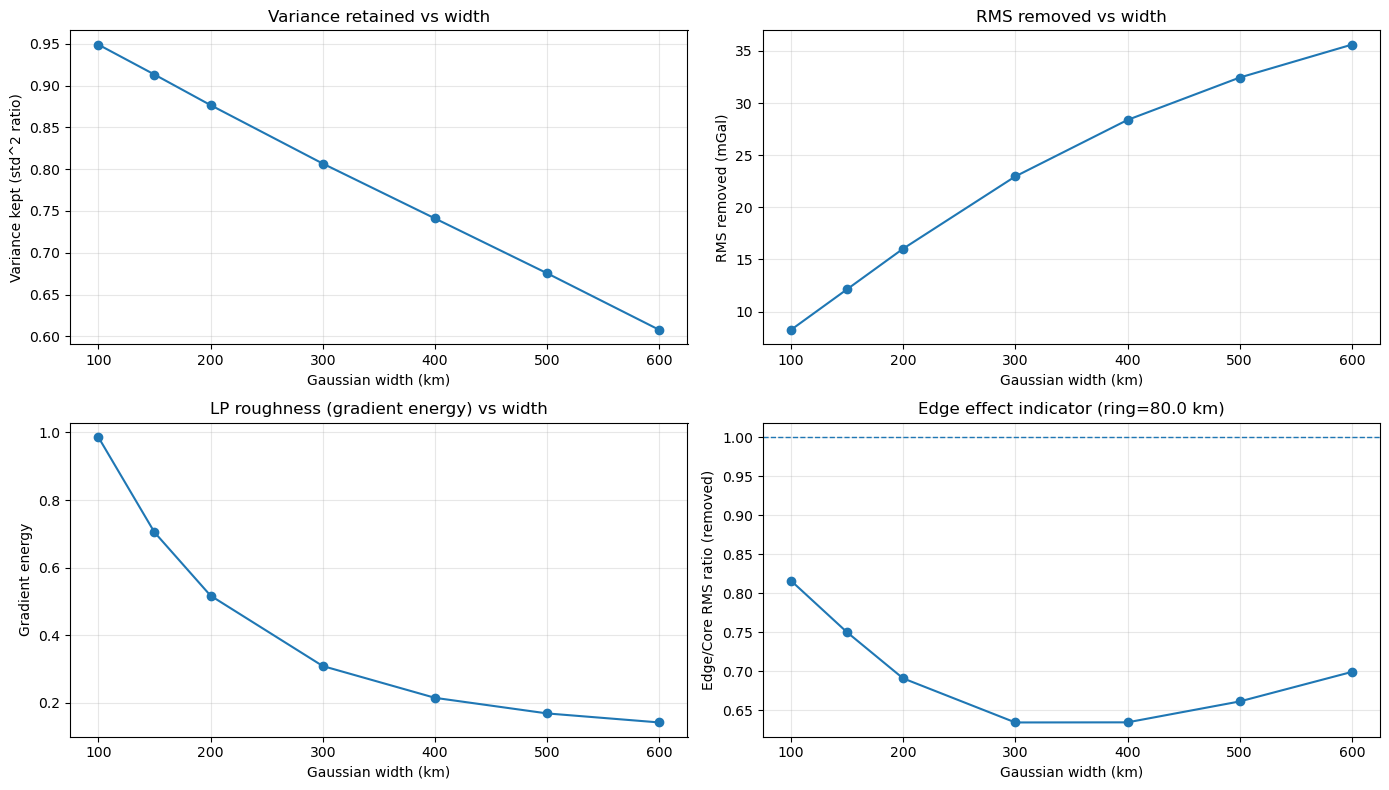

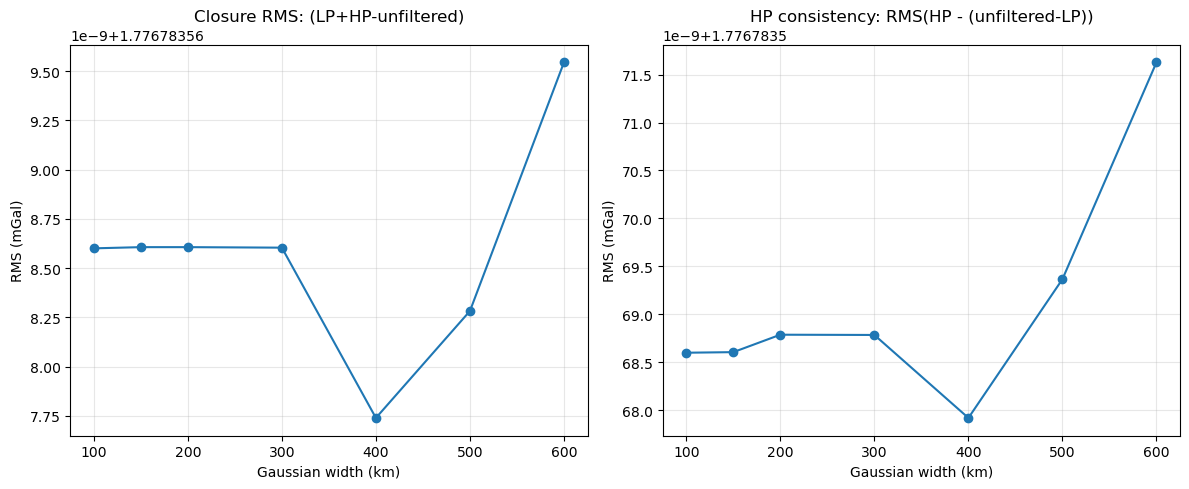

In [5]:
# compare_lp_hp_band.py
# -*- coding: utf-8 -*-
from __future__ import annotations

import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# ============== 你只需要改这里 ==============
IN_UNFILTERED = r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\Sediment_Correction_expand_crop\CBA_sed_expand5.0deg_5.0deg_rho2300.nc"
FILTER_DIR = Path(r"E:\wjy\Gravity\SCS_Gravity\out\Outdata\filter")
REGION_TARGET = [111, 117, 14.5, 18.5]
OUT_DIR = FILTER_DIR / "compare_qc_full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

EDGE_RING_KM = 80.0
# ===========================================


# ---------- 基础读网格 ----------
def _pick_data_var(ds: xr.Dataset) -> xr.DataArray:
    for v in ds.data_vars:
        da = ds[v]
        if da.ndim == 2:
            dims = set(da.dims)
            if {"lat", "lon"} <= dims or {"y", "x"} <= dims or {"latitude", "longitude"} <= dims:
                return da
    for v in ds.data_vars:
        da = ds[v]
        if da.ndim == 2:
            return da
    return next(iter(ds.data_vars.values()))


def open_grid_nc(path: str, varname: str = "z") -> xr.DataArray:
    ds = xr.open_dataset(path)
    da = ds[varname] if varname in ds.data_vars else _pick_data_var(ds)
    da = da.squeeze()

    if "x" in da.dims:
        da = da.rename({"x": "lon"})
    if "y" in da.dims:
        da = da.rename({"y": "lat"})
    if "longitude" in da.coords:
        da = da.rename({"longitude": "lon"})
    if "latitude" in da.coords:
        da = da.rename({"latitude": "lat"})

    da = da.sortby(["lat", "lon"]).rename("z")
    return da


def grdcut(da: xr.DataArray, region: List[float]) -> xr.DataArray:
    lon0, lon1, lat0, lat1 = region
    return da.sel(lon=slice(lon0, lon1), lat=slice(lat0, lat1))


def regrid_to_target(target: xr.DataArray, src: xr.DataArray) -> xr.DataArray:
    # 先裁再插值到 target 网格
    region = [float(target.lon.min()), float(target.lon.max()),
              float(target.lat.min()), float(target.lat.max())]
    src2 = grdcut(src, region)
    out = src2.interp(lon=target.lon, lat=target.lat, method="nearest").transpose("lat", "lon")
    if np.all(~np.isfinite(out.values)):
        raise ValueError("regrid_to_target: no overlap after cut/interp.")
    return out


# ---------- 尺度与边缘环带 ----------
def grid_spacing_km(da: xr.DataArray) -> Tuple[float, float]:
    lat = da.lat.values
    lon = da.lon.values
    dlat = float(np.median(np.diff(lat)))
    dlon = float(np.median(np.diff(lon)))
    lat0 = float(np.mean(lat))
    dy = 110.574 * dlat
    dx = 111.320 * np.cos(np.deg2rad(lat0)) * dlon
    return float(abs(dx)), float(abs(dy))


def edge_ring_mask(da: xr.DataArray, edge_km: float) -> xr.DataArray:
    dx_km, dy_km = grid_spacing_km(da)
    nx = da.sizes["lon"]
    ny = da.sizes["lat"]
    nx_edge = int(np.ceil(edge_km / dx_km))
    ny_edge = int(np.ceil(edge_km / dy_km))
    ix = np.arange(nx)
    iy = np.arange(ny)
    Ix, Iy = np.meshgrid(ix, iy)
    ring = (Ix < nx_edge) | (Ix >= nx - nx_edge) | (Iy < ny_edge) | (Iy >= ny - ny_edge)
    return xr.DataArray(ring, coords={"lat": da.lat, "lon": da.lon}, dims=("lat", "lon"))


# ---------- 指标 ----------
def nan_rms(v: xr.DataArray) -> float:
    x = v.values.astype(float)
    return float(np.sqrt(np.nanmean(x * x)))


def nan_std(v: xr.DataArray) -> float:
    return float(np.nanstd(v.values.astype(float)))


def roughness_grad_energy(da: xr.DataArray) -> float:
    dx_km, dy_km = grid_spacing_km(da)
    z = da.values.astype(float)
    if z.shape[0] < 3 or z.shape[1] < 3:
        return float("nan")
    dz_dy = (z[2:, 1:-1] - z[:-2, 1:-1]) / (2.0 * dy_km)
    dz_dx = (z[1:-1, 2:] - z[1:-1, :-2]) / (2.0 * dx_km)
    return float(np.nanmean(dz_dx * dz_dx + dz_dy * dz_dy))


# ---------- 发现文件 ----------
def discover_lp(filter_dir: Path) -> Dict[int, Path]:
    pat = re.compile(r"_lp_(\d+)km_target\.nc$", re.IGNORECASE)
    out = {}
    for p in filter_dir.glob("*_lp_*km_target.nc"):
        m = pat.search(p.name)
        if m:
            out[int(m.group(1))] = p
    return dict(sorted(out.items()))


def discover_hp(filter_dir: Path) -> Dict[int, Path]:
    pat = re.compile(r"_hp_(\d+)km_target\.nc$", re.IGNORECASE)
    out = {}
    for p in filter_dir.glob("*_hp_*km_target.nc"):
        m = pat.search(p.name)
        if m:
            out[int(m.group(1))] = p
    return dict(sorted(out.items()))


def discover_band(filter_dir: Path) -> Dict[str, Path]:
    out = {}
    for p in filter_dir.glob("*_band_lp*_minus_lp*_target.nc"):
        out[p.stem] = p
    return out


def main():
    z0_full = open_grid_nc(IN_UNFILTERED, "z")
    z0 = grdcut(z0_full, REGION_TARGET)

    lp_files = discover_lp(FILTER_DIR)
    hp_files = discover_hp(FILTER_DIR)
    band_files = discover_band(FILTER_DIR)

    if not lp_files:
        raise FileNotFoundError("No LP files found (*_lp_*km_target.nc)")
    if not hp_files:
        print("[WARN] No HP files found (*_hp_*km_target.nc). Closure check will still work via (unfiltered-LP).")

    ring = edge_ring_mask(z0, EDGE_RING_KM)

    rows = []

    for w, lp_fp in lp_files.items():
        lp = open_grid_nc(str(lp_fp), "z")
        lp = regrid_to_target(z0, lp)

        # removed = unfiltered - LP（这在你之前 QC 里就算过）
        removed = z0 - lp

        # HP 若存在，读入并重采样
        hp = None
        hp_fp = hp_files.get(w, None)
        if hp_fp is not None:
            hp = open_grid_nc(str(hp_fp), "z")
            hp = regrid_to_target(z0, hp)

        # --- 指标：LP ---
        std0 = nan_std(z0)
        std_lp = nan_std(lp)
        var_keep = (std_lp ** 2) / (std0 ** 2 + 1e-30)
        rough_lp = roughness_grad_energy(lp)
        rms_removed = nan_rms(removed)

        # --- 边缘效应（用 removed 做更直观） ---
        rem = removed.values
        ring_vals = rem[ring.values]
        core_vals = rem[~ring.values]
        edge_ratio = float(np.sqrt(np.nanmean(ring_vals ** 2)) / (np.sqrt(np.nanmean(core_vals ** 2)) + 1e-30))

        # --- 闭合检验 ---
        # 若有 HP：closure = (LP + HP - unfiltered)
        # 若无 HP：closure 用 0（不计算）
        closure_rms = np.nan
        hp_minus_removed_rms = np.nan
        if hp is not None:
            closure = (lp + hp) - z0
            closure_rms = nan_rms(closure)
            # HP 与 removed（unfiltered-LP）的一致性（应该接近 0）
            hp_minus_removed_rms = nan_rms(hp - removed)

        rows.append({
            "width_km": w,
            "var_keep_ratio": var_keep,
            "rms_removed_mgal": rms_removed,
            "roughness_lp": rough_lp,
            "edge_removed_rms_ratio": edge_ratio,
            "closure_rms_mgal": closure_rms,
            "hp_minus_removed_rms_mgal": hp_minus_removed_rms,
            "lp_file": str(lp_fp),
            "hp_file": str(hp_fp) if hp_fp is not None else "",
        })

    df = pd.DataFrame(rows).sort_values("width_km")
    df.to_csv(OUT_DIR / "metrics_lp_hp_band.csv", index=False)

    # ---------- 作图：LP 指标 ----------
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.plot(df["width_km"], df["var_keep_ratio"], marker="o")
    ax1.set_title("Variance retained vs width")
    ax1.set_xlabel("Gaussian width (km)")
    ax1.set_ylabel("Variance kept (std^2 ratio)")
    ax1.grid(True, alpha=0.3)

    ax2.plot(df["width_km"], df["rms_removed_mgal"], marker="o")
    ax2.set_title("RMS removed vs width")
    ax2.set_xlabel("Gaussian width (km)")
    ax2.set_ylabel("RMS removed (mGal)")
    ax2.grid(True, alpha=0.3)

    ax3.plot(df["width_km"], df["roughness_lp"], marker="o")
    ax3.set_title("LP roughness (gradient energy) vs width")
    ax3.set_xlabel("Gaussian width (km)")
    ax3.set_ylabel("Gradient energy")
    ax3.grid(True, alpha=0.3)

    ax4.plot(df["width_km"], df["edge_removed_rms_ratio"], marker="o")
    ax4.axhline(1.0, linestyle="--", linewidth=1)
    ax4.set_title(f"Edge effect indicator (ring={EDGE_RING_KM} km)")
    ax4.set_xlabel("Gaussian width (km)")
    ax4.set_ylabel("Edge/Core RMS ratio (removed)")
    ax4.grid(True, alpha=0.3)

    fig.tight_layout()
    fig.savefig(OUT_DIR / "metrics_lp_hp.png", dpi=200)

    # ---------- 作图：闭合检验 ----------
    if np.any(np.isfinite(df["closure_rms_mgal"].values)):
        fig2 = plt.figure(figsize=(12, 5))
        ax = fig2.add_subplot(121)
        ax.plot(df["width_km"], df["closure_rms_mgal"], marker="o")
        ax.set_title("Closure RMS: (LP+HP-unfiltered)")
        ax.set_xlabel("Gaussian width (km)")
        ax.set_ylabel("RMS (mGal)")
        ax.grid(True, alpha=0.3)

        ax = fig2.add_subplot(122)
        ax.plot(df["width_km"], df["hp_minus_removed_rms_mgal"], marker="o")
        ax.set_title("HP consistency: RMS(HP - (unfiltered-LP))")
        ax.set_xlabel("Gaussian width (km)")
        ax.set_ylabel("RMS (mGal)")
        ax.grid(True, alpha=0.3)

        fig2.tight_layout()
        fig2.savefig(OUT_DIR / "closure_check.png", dpi=200)

    # ---------- band 文件清单 ----------
    if band_files:
        pd.DataFrame({"band_file": [str(p) for p in band_files.values()]}).to_csv(OUT_DIR / "band_files_found.csv", index=False)

    print("Done:", OUT_DIR)
    print("LP count:", len(lp_files), "HP count:", len(hp_files), "BAND count:", len(band_files))


if __name__ == "__main__":
    main()


In [ ]:
# hun_region_topography_detector_deep.py
# -*- coding: utf-8 -*-
"""
绘制 111E–117E, 14.5N–18.5N 区域的高分辨率地形/水深图，
并标出 HUNT 探测器位置 (16.5N, 114E)。
"""

import os
import pygmt

# =============== 区域 & 参数 ===============
REGION = [111, 117, 14.5, 18.5]   # [lon_min, lon_max, lat_min, lat_max]
PROJ   = "M16c"                   # 墨卡托投影 + 图幅宽约 16 cm
OUTPNG = r"E:\wjy\Gravity\SCS_Gravity\out\pic\SCS_111-117E_14p5-18p5N_topography_15s_deep_detector.png"

# 优先使用本地 GEBCO（15″）
USE_GEBCO  = True
GEBCO_PATH = r"E:\wjy\Gravity\data\GEBCO_2021.nc"

# 只绘制海盆：陆地灰色，海底用色带
SEA_ONLY = True

# 颜色带：改用 cmocean 的 "deep"，典型深海配色
CPT_NAME          = "vik"
CPT_STEP          = 100
CPT_SERIES_MANUAL = [-5500, 0, 100]   # min, max, step（单位 m）

# 探测器位置
DETECTOR_LON = 114.0
DETECTOR_LAT = 16.5


def main() -> None:
    # =============== 1. 读取栅格数据 ===============
    if USE_GEBCO and os.path.exists(GEBCO_PATH):
        print("Using local GEBCO_2021 grid ...")
        grid = pygmt.grdcut(grid=GEBCO_PATH, region=REGION)
    else:
        try:
            print("Using remote earth_relief_15s ...")
            grid = pygmt.datasets.load_earth_relief(
                resolution="15s",
                region=REGION,
            )
        except Exception:
            print("15s not available, fallback to earth_relief_01m ...")
            grid = pygmt.datasets.load_earth_relief(
                resolution="01m",
                region=REGION,
            )

    # 若只想显示海盆，把高于 0 m 的区域裁剪为 NaN
    grid_to_plot = grid
    if SEA_ONLY:
        grid_to_plot = pygmt.grdclip(grid=grid, above=[0, float("nan")])

    # =============== 2. 颜色带（deep，高对比但整体偏暗） ===============
    pygmt.makecpt(
        cmap=CPT_NAME,
        series=CPT_SERIES_MANUAL,
        continuous=True,
    )

    # =============== 3. 画图 ===============
    fig = pygmt.Figure()
    pygmt.config(
        MAP_FRAME_TYPE="plain",
        FORMAT_GEO_MAP="dddF",
        MAP_TICK_LENGTH_PRIMARY="0.15c",
    )

    # 底图 + 明暗（由 grdimage 自动从 grid_to_plot 生成）
    fig.grdimage(
        grid=grid_to_plot,
        projection=PROJ,
        region=REGION,
        # 光照方位 315°，ne=0.4 明暗更柔和，整体不那么“亮”
        shading="+a315+ne0.4",
        cmap=True,
    )

    # 海岸线 / 边界 / 坐标网格
    if SEA_ONLY:
        fig.coast(
            land="gray90",
            shorelines="0.25p,black",
            borders="1/0.15p,gray40",
            frame=["WSen", "xafg", "yafg"],
        )
    else:
        fig.coast(
            shorelines="0.25p,black",
            borders="1/0.15p,gray40",
            frame=["WSen", "xafg", "yafg"],
        )

    # =============== HUNT 探测器位置 ===============
    fig.plot(
        x=[DETECTOR_LON],
        y=[DETECTOR_LAT],
        style="a0.5c",           # 五角星
        fill="yellow",
        pen="0.7p,black",
    )

    fig.text(
        x=DETECTOR_LON,
        y=DETECTOR_LAT,
        text="HUNT Detector",
        justify="LB",
        offset="0.15c/0.25c",
        font="10p,black,Helvetica-Bold",
        fill="white@60",
        clearance="1p/1p",
        pen="0.3p,black",
    )

    # colorbar：刻度 1000 m、次刻度 500 m，疏一些
    fig.colorbar(
        position="JBC+w14c/0.45c+o0c/0.8c+h",
        frame="a1000f500+lBathymetry (m)",
    )

    # =============== 4. 导出 ===============
    os.makedirs(os.path.dirname(OUTPNG), exist_ok=True)
    fig.savefig(OUTPNG, dpi=600)
    print(f"Saved figure to: {OUTPNG}")


if __name__ == "__main__":
    main()


In [1]:
# hun_region_topography_detector_deep.py
# -*- coding: utf-8 -*-
"""
绘制 111E–117E, 14.5N–18.5N 区域的高分辨率地形/水深图，
并标出 HUNT 探测器位置 (16.5N, 114E)。
另外绘制 3000 m 等深线。
"""

import os
import pygmt

# =============== 区域 & 参数 ===============
REGION = [111, 117, 14.5, 18.5]   # [lon_min, lon_max, lat_min, lat_max]
PROJ   = "M16c"                   # 墨卡托投影 + 图幅宽约 16 cm
OUTPNG = r"E:\wjy\Gravity\SCS_Gravity\out\pic\SCS_111-117E_14p5-18p5N_topography_15s_vik_detector.png"

# 优先使用本地 GEBCO（15″）
USE_GEBCO  = True
GEBCO_PATH = r"E:\wjy\Gravity\data\GEBCO_2021.nc"

# 只绘制海盆：陆地灰色，海底用色带
SEA_ONLY = True

# 颜色带
CPT_NAME          = "vik"
CPT_STEP          = 100
CPT_SERIES_MANUAL = [-5500, 1000, 100]   # min, max, step（单位 m）

# 探测器位置
DETECTOR_LON = 114.0
DETECTOR_LAT = 16.5

# 3000 m 等深线（注意：海水深度通常为负值）
ISO_DEPTH_M = 3000.0
ISO_LEVEL_Z = -ISO_DEPTH_M


def main() -> None:
    # =============== 1. 读取栅格数据 ===============
    if USE_GEBCO and os.path.exists(GEBCO_PATH):
        print("Using local GEBCO_2021 grid ...")
        grid = pygmt.grdcut(grid=GEBCO_PATH, region=REGION)
    else:
        try:
            print("Using remote earth_relief_15s ...")
            grid = pygmt.datasets.load_earth_relief(
                resolution="15s",
                region=REGION,
            )
        except Exception:
            print("15s not available, fallback to earth_relief_01m ...")
            grid = pygmt.datasets.load_earth_relief(
                resolution="01m",
                region=REGION,
            )

    # 若只想显示海盆，把高于 0 m 的区域裁剪为 NaN
    grid_to_plot = grid
    if SEA_ONLY:
        grid_to_plot = pygmt.grdclip(grid=grid, above=[0, float("nan")])

    # =============== 2. 颜色带 ===============
    pygmt.makecpt(
        cmap=CPT_NAME,
        series=CPT_SERIES_MANUAL,
        continuous=True,
    )

    # =============== 3. 画图 ===============
    fig = pygmt.Figure()
    pygmt.config(
        MAP_FRAME_TYPE="plain",
        FORMAT_GEO_MAP="dddF",
        MAP_TICK_LENGTH_PRIMARY="0.15c",
    )

    # 底图 + 明暗（由 grdimage 自动从 grid_to_plot 生成）
    fig.grdimage(
        grid=grid_to_plot,
        projection=PROJ,
        region=REGION,
        shading="+a315+ne0.4",
        cmap=True,
    )

    # 海岸线/边界/网格
    if SEA_ONLY:
        fig.coast(
            land="gray90",
            shorelines="0.25p,black",
            borders="1/0.15p,gray40",
            frame=["WSen", "xafg", "yafg"],
        )
    else:
        fig.coast(
            shorelines="0.25p,black",
            borders="1/0.15p,gray40",
            frame=["WSen", "xafg", "yafg"],
        )

    # =============== 3000 m 等深线 ===============
    # 白底粗线（增强在复杂背景上的可读性）
    fig.grdcontour(
        grid=grid,
        levels=[ISO_LEVEL_Z],   # -3000
        pen="2.2p,white",
    )
    # 黑边细线
    fig.grdcontour(
        grid=grid,
        levels=[ISO_LEVEL_Z],
        pen="1.0p,black",
    )

    # =============== HUNT 探测器位置 ===============
    fig.plot(
        x=[DETECTOR_LON],
        y=[DETECTOR_LAT],
        style="a0.5c",           # 五角星
        fill="yellow",
        pen="0.7p,black",
    )

    fig.text(
        x=DETECTOR_LON,
        y=DETECTOR_LAT,
        text="HUNT Detector",
        justify="LB",
        offset="0.15c/0.25c",
        font="10p,black,Helvetica-Bold",
        fill="white@60",
        clearance="1p/1p",
        pen="0.3p,black",
    )

    # colorbar
    fig.colorbar(
        position="JBC+w14c/0.45c+o0c/0.8c+h",
        frame="a1000f500+lBathymetry (m)",
    )

    # =============== 4. 导出 ===============
    os.makedirs(os.path.dirname(OUTPNG), exist_ok=True)
    fig.savefig(OUTPNG, dpi=600)
    print(f"Saved figure to: {OUTPNG}")


if __name__ == "__main__":
    main()


Using remote earth_relief_15s ...


text [WARNING]: Representation of font type not recognized. Using default.
text [ERROR]: Colorname Helvetica-Bold not recognized!
text [WARNING]: Representation of font fill not recognized. Using default.


Saved figure to: E:\wjy\Gravity\SCS_Gravity\out\pic\SCS_111-117E_14p5-18p5N_topography_15s_vik_detector.png
